In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, Callback

# Add src to path
sys.path.insert(0, '../..')
from src.modeling.data_generator import create_train_generator, create_val_test_generator
from src.modeling.model_cnn import build_cnn_model, enable_gpu_memory_growth

# Setup
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
enable_gpu_memory_growth()
plt.style.use('seaborn-v0_8-darkgrid')

2025-10-22 14:29:41.701125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.20.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
‚úÖ Memory growth enabled for 1 GPU(s)


In [2]:
# Output directories
MODELS_DIR = '../../outputs/models'
LOGS_DIR = '../../outputs/logs'
VIZ_DIR = '../../outputs/visualizations'

for directory in [MODELS_DIR, LOGS_DIR, VIZ_DIR]:
    os.makedirs(directory, exist_ok=True)

print("‚úÖ Directories ready")

‚úÖ Directories ready


In [3]:
# üõ†Ô∏è Configure Callbacks
# 1. Early Stopping - stop when val_loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# 2. Model Checkpoint - save best model
checkpoint_path = os.path.join(MODELS_DIR, 'model_cnn_best.h5')
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 3. Reduce LR - halve learning rate when plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# 4. CSV Logger - log metrics
csv_log_path = os.path.join(LOGS_DIR, 'training_log.csv')
csv_logger = CSVLogger(csv_log_path)

# 5. Custom LR Tracker
class LRTracker(Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []
    
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)
        logs['lr'] = lr

lr_tracker = LRTracker()

# Combine all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, csv_logger, lr_tracker]

print(f"‚úÖ Configured {len(callbacks_list)} callbacks:")
for i, cb in enumerate(callbacks_list, 1):
    print(f"   {i}. {type(cb).__name__}")

‚úÖ Configured 5 callbacks:
   1. EarlyStopping
   2. ModelCheckpoint
   3. ReduceLROnPlateau
   4. CSVLogger
   5. LRTracker


In [4]:
# üß™ Test Callbacks with Short Training
print("üß™ Testing callbacks with 2-epoch training...\n")

# Load data
train_gen = create_train_generator('../../outputs/data_splits/train_split.csv', batch_size=32)
val_gen = create_val_test_generator('../../outputs/data_splits/val_split.csv', batch_size=32)

# Build model
model = build_cnn_model(input_shape=(128, 128, 1), num_classes=3, learning_rate=1e-4)

# Train with callbacks
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=callbacks_list,
    verbose=1
)

print("\n‚úÖ Test complete!")

üß™ Testing callbacks with 2-epoch training...

Found 2059 validated image filenames belonging to 3 classes.
‚úÖ Training generator created
   Images: 2059
   Batches: 65
   Classes: {'1': 0, '2': 1, '3': 2}
Found 325 validated image filenames belonging to 3 classes.
‚úÖ Training generator created
   Images: 2059
   Batches: 65
   Classes: {'1': 0, '2': 1, '3': 2}
Found 325 validated image filenames belonging to 3 classes.
‚úÖ Generator created
   Images: 325
   Batches: 11
   Shuffle: False
‚úÖ Generator created
   Images: 325
   Batches: 11
   Shuffle: False


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761123584.054244   95809 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 755 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


‚úÖ Model built and compiled successfully
   Input shape: (128, 128, 1)
   Output classes: 3
   Learning rate: 0.0001
Epoch 1/2


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-22 14:29:45.696407: I external/local_xla/xla/service/service.cc:163] XLA service 0x7814c00067e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 14:29:45.696427: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-22 14:29:45.726681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-22 14:29:45.696407: I external/local_xla/xla/service/service

 5/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step - accuracy: 0.3770 - loss: 1.0809

I0000 00:00:1761123589.008304   97029 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step - accuracy: 0.5108 - loss: 0.9998

2025-10-22 14:29:50.288550: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-22 14:29:50.331815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,32,64,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 67ms/step - accuracy: 0.5541 - loss: 0.9528

2025-10-22 14:29:53.611410: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-22 14:29:53.626113: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-10-22 14:29:53.628979: I external/loc


Epoch 1: val_accuracy improved from None to 0.70769, saving model to ../../outputs/models/model_cnn_best.h5


65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 96ms/step - accuracy: 0.6037 - loss: 0.8928 - val_accuracy: 0.7077 - val_loss: 0.7075 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Epoch 2/2
Epoch 2/2
64/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 31ms/step - accuracy: 0.6275 - loss: 0.8082
Epoch 2: val_accuracy improved from 0.70769 to 0.74769, saving model to ../../outputs/models/model_cnn_best.h5

Epoch 2: val_accuracy improved from 0.70769 to 0.74769, saving model to ../../outputs/models/model_cnn_best.h5


65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 36ms/step - accuracy: 0.6406 - loss: 0.8060 - val_accuracy: 0.7477 - val_loss: 0.6474 - learning_rate: 1.0000e-04 - lr: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.
Restoring model weights from the end of the best epoch: 2.

‚úÖ Test complete!

‚úÖ Test complete!


‚úÖ Model saved: ../../outputs/models/model_cnn_best.h5 (49.1 MB)

‚úÖ Training log: ../../outputs/logs/training_log.csv
   Columns: ['epoch', 'accuracy', 'learning_rate', 'loss', 'val_accuracy', 'val_loss']

   epoch  accuracy  learning_rate      loss  val_accuracy  val_loss
0      0  0.603691         0.0001  0.892764      0.707692  0.707465
1      1  0.640602         0.0001  0.806024      0.747692  0.647421

‚úÖ LR plot saved

‚úÖ LR plot saved


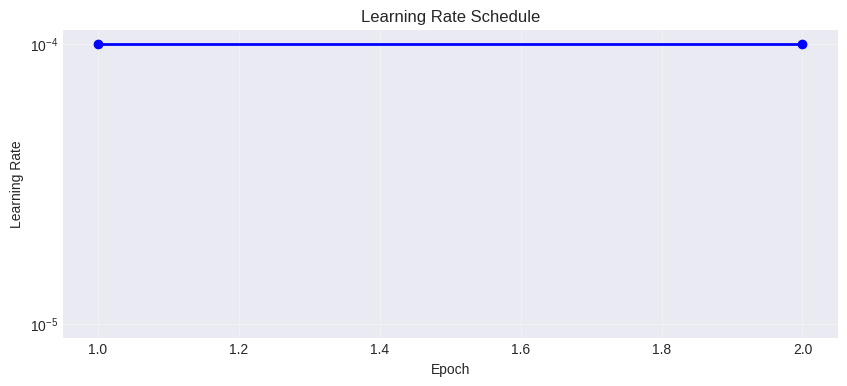

In [5]:

# Check checkpoint
if os.path.exists(checkpoint_path):
    size_mb = os.path.getsize(checkpoint_path) / (1024 * 1024)
    print(f"‚úÖ Model saved: {checkpoint_path} ({size_mb:.1f} MB)")
else:
    print("‚ùå Model not saved")

# Check logs
if os.path.exists(csv_log_path):
    log_df = pd.read_csv(csv_log_path)
    print(f"\n‚úÖ Training log: {csv_log_path}")
    print(f"   Columns: {list(log_df.columns)}")
    print(f"\n{log_df}")
else:
    print("\n‚ùå Log not created")

# Plot LR
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(lr_tracker.lrs)+1), lr_tracker.lrs, 'b-o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(VIZ_DIR, 'day4_01_lr_schedule_test.png'), dpi=150, bbox_inches='tight')
print("\n‚úÖ LR plot saved")
plt.show()

## ‚úÖ Summary

**Callbacks configured:**
1. EarlyStopping - stops at overfitting
2. ModelCheckpoint - saves best model
3. ReduceLROnPlateau - adjusts learning rate
4. CSVLogger - logs metrics
5. LRTracker - tracks LR changes

**Ready for full training in Day 4.2!**

---
**Status:** ‚úÖ Complete  
**Next:** `day4_02_full_training.ipynb`